In [4]:
# 导入必要的库
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta





In [5]:
# 配置
DATA_DIR = r"data\Air pollution data\FI"
URLS_CSV = r"data\Air pollution data\FI\ParquetFilesUrlse1a.csv"

# 设置固定日期范围
START_DATE = "2020-10-01"
END_DATE = "2025-09-30"
# 预测开始日期
PREDICTION_START_DATE = "2025-10-01"

print(f'Fetching data from {START_DATE} to {END_DATE}')
print(f'Prediction will start from {PREDICTION_START_DATE} for one year')

# 下载parquet文件的函数
def download_parquet_files(urls_csv, data_dir):
    # 从CSV文件读取URLs
    urls = pd.read_csv(urls_csv)["ParquetFileUrl"]
    # 下载每个文件
    for url in urls:
        file_name = url.split('/')[-1]
        file_path = os.path.join(data_dir, file_name)
        # 只在文件不存在时下载
        if not os.path.exists(file_path):
            print(f'Downloading {file_name}...')
            try:
                response = requests.get(url)
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    f.write(response.content)
            except Exception as e:
                print(f'Error downloading {file_name}: {e}')
        else:
            print(f'{file_name} already exists, skipping download.')


Fetching data from 2020-10-01 to 2025-09-30
Prediction will start from 2025-10-01 for one year


In [6]:
# 加载和预处理空气污染数据的函数
def load_air_pollution_data(data_dir, start_date, end_date):
    # 定义要读取的列
    columns_air = ["Samplingpoint", "Pollutant", "Start", "Value", "Unit", "Validity"]
    
    # 初始化空DataFrame
    df_air = pd.DataFrame()
    
    # 遍历目录并读取所有parquet文件
    for root, _, files in os.walk(data_dir):
        for filename in files:
            if filename.endswith('.parquet'):
                file_path = os.path.join(root, filename)
                try:
                    # 读取parquet文件
                    data = pd.read_parquet(file_path, columns=columns_air)
                    # 合并到主DataFrame
                    df_air = pd.concat([df_air, data])
                except Exception as e:
                    print(f'Error reading {filename}: {e}')
    
    # 数据清洗和预处理
    if not df_air.empty:
        # 将Start列转换为datetime类型
        df_air['Start'] = pd.to_datetime(df_air['Start'])
        
        # 按日期范围过滤数据
        df_air = df_air[(df_air['Start'] >= start_date) & (df_air['Start'] <= end_date)]
        
        # 只保留有效数据
        df_air = df_air[df_air['Validity'] == 1]
        
        # 移除Validity列，因为不再需要
        df_air = df_air.drop(['Validity'], axis=1)
        
        # 从Samplingpoint中移除国家代码前缀
        if 'Samplingpoint' in df_air.columns:
            df_air['Samplingpoint'] = df_air['Samplingpoint'].str[3:]
        
        # 将Value转换为float并处理负值
        df_air['Value'] = pd.to_numeric(df_air['Value'], errors='coerce')
        df_air['Value'] = df_air['Value'].where(lambda x: x > 0, np.nan)
        
        # 前向填充缺失值
        df_air = df_air.ffill()
        
        # 删除任何剩余的NaN值
        df_air = df_air.dropna()
    
    return df_air

# 执行数据获取
print('Downloading parquet files...')
download_parquet_files(URLS_CSV, DATA_DIR)

print('\nLoading and preprocessing air pollution data...')
df_air = load_air_pollution_data(DATA_DIR, START_DATE, END_DATE)

print(f'\nLoaded {len(df_air)} records')
if not df_air.empty:
    print('\nSample data:')
    print(df_air.head())
    print('\nData summary:')
    print(df_air.describe())

# 为GRU准备时间序列数据的函数
def prepare_time_series_data(df, pollutant_id, station_id=None, sequence_length=24):
    # 过滤特定污染物的数据
    df_pollutant = df[df['Pollutant'] == pollutant_id].copy()
    
    # 如果指定了站点，则按站点过滤
    if station_id:
        df_pollutant = df_pollutant[df_pollutant['Samplingpoint'] == station_id]
    
    # 按日期排序
    df_pollutant = df_pollutant.sort_values('Start')
    
    # 提取值和日期
    values = df_pollutant['Value'].values
    dates = df_pollutant['Start'].values
    
    # 归一化数据
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values.reshape(-1, 1))
    
    # 创建时间序列预测序列
    X, y, y_dates = [], [], []
    
    for i in range(len(values_scaled) - sequence_length):
        X.append(values_scaled[i:i+sequence_length, 0])
        y.append(values_scaled[i+sequence_length, 0])
        y_dates.append(dates[i+sequence_length])
    
    # 转换为numpy数组并重塑为GRU输入格式
    X = np.array(X)
    y = np.array(y)
    
    # 重塑X为LSTM/GRU输入格式：[samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, y_dates


SPO-FI00027_00001_100.parquet already exists, skipping download.
SPO-FI00027_06001_100.parquet already exists, skipping download.
SPO-FI00074_00005_100.parquet already exists, skipping download.
SPO-FI00074_06001_100.parquet already exists, skipping download.
SPO-FI00080_00001_100.parquet already exists, skipping download.
SPO-FI00080_00005_100.parquet already exists, skipping download.
SPO-FI00179_00001_100.parquet already exists, skipping download.
SPO-FI00179_00005_100.parquet already exists, skipping download.
SPO-FI00184_00001_100.parquet already exists, skipping download.
SPO-FI00184_00005_100.parquet already exists, skipping download.
SPO-FI00186_00005_100.parquet already exists, skipping download.
SPO-FI00186_00010_100.parquet already exists, skipping download.
SPO-FI00206_00001_100.parquet already exists, skipping download.
SPO-FI00206_00005_100.parquet already exists, skipping download.
SPO-FI00208_00001_100.parquet already exists, skipping download.
SPO-FI00208_00005_101.par

In [7]:
# 自定义PyTorch数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 选择特定污染物进行预测（例如，ID为6001的PM2.5）
pollutant_id = 6001  # PM2.5
sequence_length = 24  # 使用24小时数据预测下一小时

if not df_air.empty:
    print(f'Preparing data for pollutant ID: {pollutant_id}')
    X, y, scaler, y_dates = prepare_time_series_data(df_air, pollutant_id, sequence_length=sequence_length)
    
    print(f'Prepared {X.shape[0]} samples for training')
    
    # 将数据分为训练集和测试集
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    test_dates = y_dates[train_size:]
    
    print(f'Train samples: {len(X_train)}, Test samples: {len(X_test)}')
    
    # 创建DataLoader实例
    batch_size = 32
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GRU模型定义
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h=None):
        # 如果没有提供隐藏状态，则初始化为零
        if h is None:
            h = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, h_n = self.gru(x, h)
        out = self.fc(out[:, -1, :])  # 只使用最后一个时间步的输出
        
        return out, h_n



Preparing data for pollutant ID: 6001
Prepared 193559 samples for training
Train samples: 154847, Test samples: 38712


Initializing and training GRU model...
Epoch [10/50], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [20/50], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [30/50], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [40/50], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [50/50], Train Loss: 0.0002, Test Loss: 0.0002


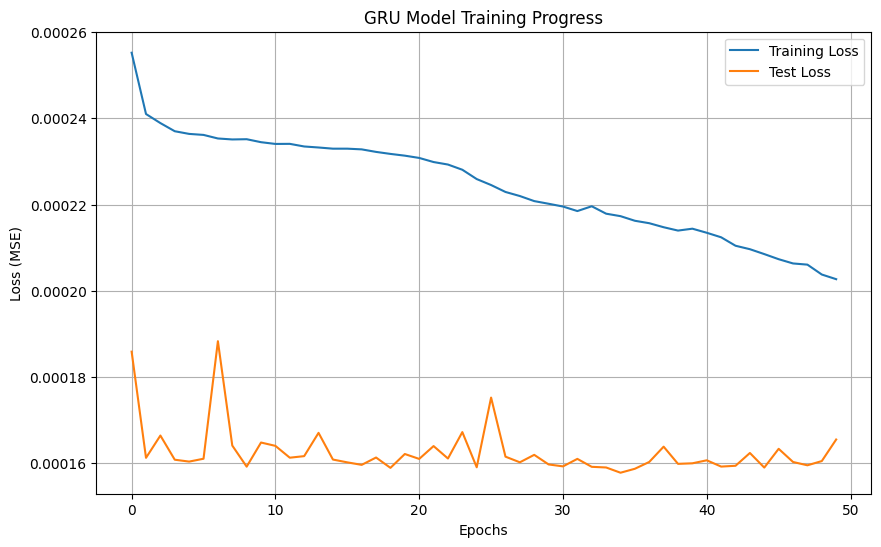

In [ ]:
# 训练函数
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    # 设置设备（可用GPU时使用GPU，否则使用CPU）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 训练历史
    train_losses = []
    test_losses = []
    
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 前向传播 - 修复：提取元组中的第一个元素作为输出
            outputs, _ = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # 计算平均训练损失
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 在测试集上评估
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # 前向传播 - 修复：提取元组中的第一个元素作为输出
                outputs, _ = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item() * X_batch.size(0)
        
        # 计算平均测试损失
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        # 打印进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return model, train_losses, test_losses

# 如果有数据则训练模型
if 'X_train' in locals():
    print('Initializing and training GRU model...')
    
    # 创建模型实例
    model = GRUModel(input_size=1, hidden_size=64, num_layers=2, output_size=1)
    
    # 训练模型
    model, train_losses, test_losses = train_model(
        model, train_loader, test_loader, num_epochs=50, learning_rate=0.001
    )
    
    # 绘制训练和测试损失
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('GRU Model Training Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()



In [10]:
# 评估模型并进行预测的函数
def evaluate_model(model, test_loader):
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # 存储预测和实际值的字典
    all_predictions = []
    all_actuals = []
    
    # 在测试集上进行预测
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            # 修复：提取元组中的第一个元素作为预测
            predictions, _ = model(X_batch)
            
            # 转换为numpy并反向转换
            predictions_np = predictions.cpu().numpy()
            y_batch_np = y_batch.numpy()
            
            # 反向转换以获取实际值
            predictions_inv = scaler.inverse_transform(predictions_np.reshape(-1, 1)).flatten()
            actuals_inv = scaler.inverse_transform(y_batch_np.reshape(-1, 1)).flatten()
            
            all_predictions.extend(predictions_inv)
            all_actuals.extend(actuals_inv)
    
    # 计算评估指标
    mse = mean_squared_error(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f'Model Evaluation Metrics:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    
    return all_predictions, all_actuals, rmse, mae

Evaluating model performance...
Model Evaluation Metrics:
RMSE: 3.1580
MAE: 1.9076


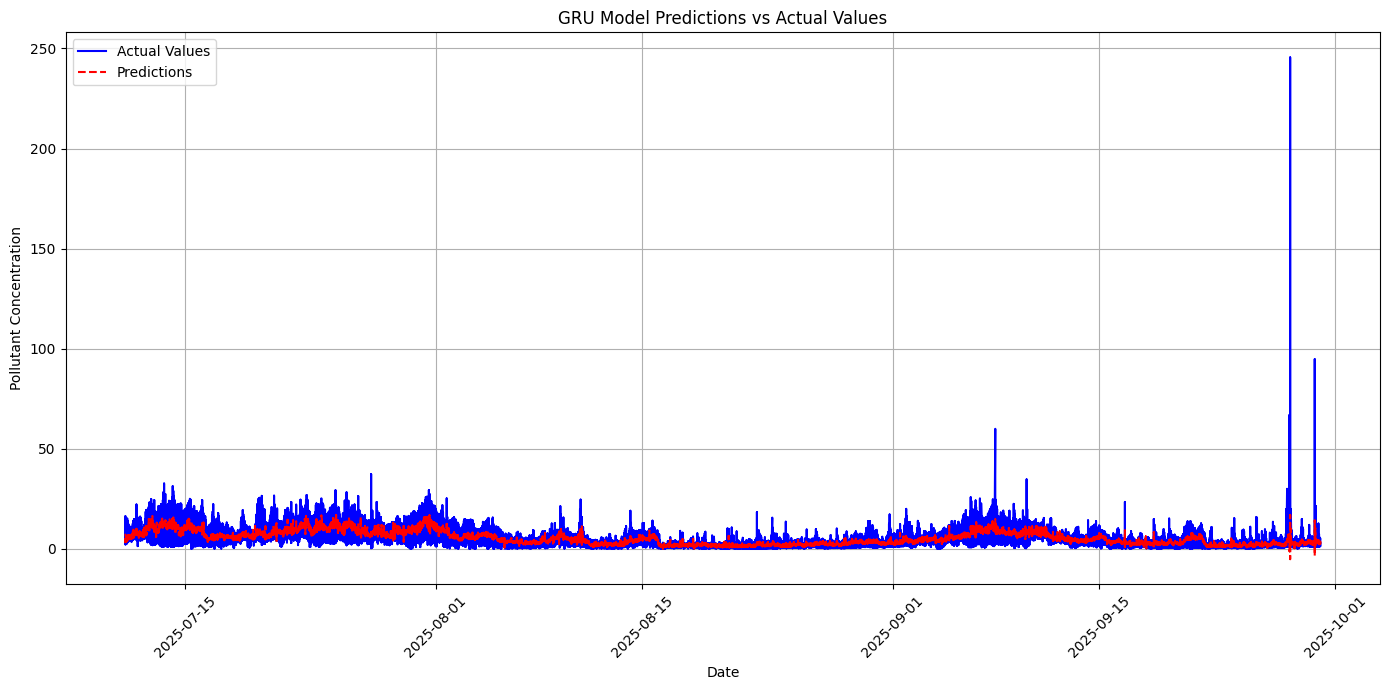

In [11]:
# 如果模型存在则评估
if 'model' in locals():
    print('Evaluating model performance...')
    predictions, actuals, rmse, mae = evaluate_model(model, test_loader)
    
    # 绘制预测值与实际值对比
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates[:len(predictions)], actuals, label='Actual Values', color='blue')
    plt.plot(test_dates[:len(predictions)], predictions, label='Predictions', color='red', linestyle='--')
    plt.title('GRU Model Predictions vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Pollutant Concentration')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()





In [12]:
# 修改predict_future_with_hidden函数
def predict_future_with_hidden(model, last_sequence, scaler, prediction_days=365):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    current_sequence = torch.tensor(last_sequence, dtype=torch.float32).to(device)
    current_sequence = current_sequence.unsqueeze(0)
    
    future_predictions = []
    hidden_state = None  # 保留隐藏状态
    
    for _ in range(prediction_days * 24):
        with torch.no_grad():
            next_pred, hidden_state = model(current_sequence, hidden_state)
            
            # 克隆隐藏状态以避免梯度问题
            hidden_state = hidden_state.clone()
            
            next_pred_np = next_pred.cpu().numpy()[0][0]
            future_predictions.append(next_pred_np)
            
            # 更新序列
            new_sequence = torch.cat([
                current_sequence[:, 1:, :],
                next_pred.unsqueeze(2)
            ], dim=1)
            current_sequence = new_sequence
    
    # 将预测值转换为数组
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    
    # 添加这一行：确保所有预测值都在[0,1]范围内
    future_predictions = np.clip(future_predictions, 0, 1)
    
    # 反归一化获取实际值
    future_predictions_inv = scaler.inverse_transform(future_predictions).flatten()
    
    return future_predictions_inv

Making predictions for the current year...


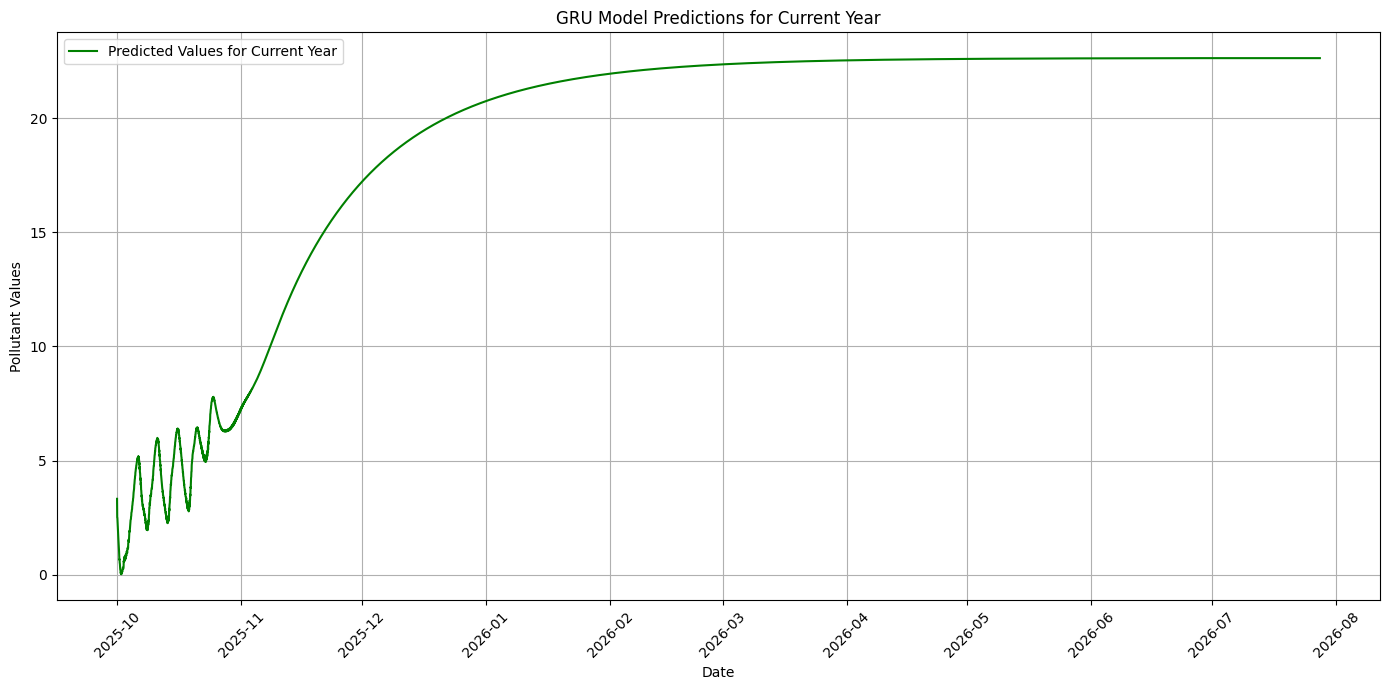

Predictions saved to current_year_predictions.csv

Summary of Current Year Predictions:
Minimum predicted level: 0.02
Maximum predicted level: 22.63
Average predicted level: 19.26
Standard deviation: 5.87


In [13]:
# 如果模型存在则进行未来预测
if 'model' in locals() and 'X_test' in locals() and 'scaler' in locals():
    print('Making predictions for the current year...')
    
    # 获取测试数据中的最后一个序列
    last_sequence = X_test[-1]
    
    # 预测今年（简化为365天）
    current_year_predictions = predict_future_with_hidden(model, last_sequence, scaler, prediction_days=300)
    
    prediction_start = datetime.strptime(PREDICTION_START_DATE, '%Y-%m-%d')
    future_dates = [prediction_start + timedelta(hours=i) for i in range(len(current_year_predictions))]
    
    # 绘制未来预测
    plt.figure(figsize=(14, 7))
    plt.plot(future_dates, current_year_predictions, color='green', label='Predicted Values for Current Year')
    plt.title('GRU Model Predictions for Current Year')
    plt.xlabel('Date')
    plt.ylabel('Pollutant Values')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 保存预测到CSV
    pred_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Pollutant_Level': current_year_predictions
    })
    
    pred_csv_path = 'current_year_predictions.csv'
    pred_df.to_csv(pred_csv_path, index=False)
    print(f'Predictions saved to {pred_csv_path}')
    
    # 显示预测的汇总统计
    print('\nSummary of Current Year Predictions:')
    print(f'Minimum predicted level: {current_year_predictions.min():.2f}')
    print(f'Maximum predicted level: {current_year_predictions.max():.2f}')
    print(f'Average predicted level: {current_year_predictions.mean():.2f}')
    print(f'Standard deviation: {current_year_predictions.std():.2f}')